# Image classification with `skorch`

**Make sure you look at [`Image classification`](Image_classification.ipynb) before coming here.**

**I recommend using the notebook [`Image classification with PyTorch`](Image_classification_with_Scikit-Learn.ipynb) instead of this one.**

We'll use `Pytorch` together with supporting libraries `tensorlayers` and `skorch` to train a classifier for fossil images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## The fossil dataset

Let's generate a workflow to classify images using a CNN.
We'll make use of a collection of functions in `utils.py` to help process the images found in the `data/fossils` folder.

In [2]:
import numpy as np

ds = np.DataSource('../data/')

X = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_X.npy', mode='rb'))
y = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_y.npy', mode='rb'))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
X_train.shape

(498, 1024)

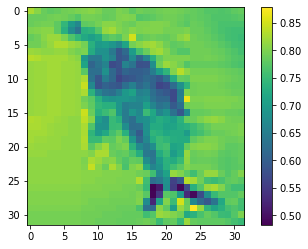

In [5]:
plt.imshow(X_train[1].reshape(32,32))
plt.colorbar()

## A convolutional neural network with skorch

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(np.append(y_train, y_val))

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

Skorch can use NumPY arrays, which is nice, but for some reason they have to be single precision (i.e. 32-bit floats).

In [18]:
X_train = X_train.reshape(-1, 1, 32, 32).astype(np.float32)
X_val = X_val.reshape(-1, 1, 32, 32).astype(np.float32)

In [14]:
import torch
from torch import nn
import torchlayers as tl

# torch.nn and torchlayers can be mixed easily.
net_arch = torch.nn.Sequential(
    tl.Conv(32, kernel_size=3),  # specify ONLY out_channels
    nn.ELU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),
    tl.Conv(16, kernel_size=3),
    nn.ELU(),  
    tl.BatchNorm(),
    tl.GlobalMaxPool(),
    tl.Linear(100), # Add a fully connected hidden layer
    tl.ELU(), # Activate the hidden layer
    tl.Linear(3),  # Output for 3 classes
    tl.Softmax(dim=-1)
)

net = tl.build(net_arch, torch.randn(1, *X_train[0].shape))

In [15]:
net

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ELU(alpha=1.0)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ELU(alpha=1.0)
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): GlobalMaxPool()
  (7): Linear(in_features=16, out_features=100, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=100, out_features=3, bias=True)
  (10): Softmax(dim=-1)
)

In [16]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint

# Callbacks.
cp = Checkpoint(dirname='skorch_cp')
es = EarlyStopping(monitor='valid_loss', patience=9)

cnn = NeuralNetClassifier(
    net,
    max_epochs=100,
    batch_size=100,
    lr=0.002,
    optimizer=torch.optim.Adam,
    callbacks=[cp, es],
)

In [17]:
cnn.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.1536       0.3200        1.1065     +  0.3625
      2        1.0293       0.3200        1.1053     +  0.4201
      3        1.0114       0.3200        1.1014     +  0.4789
      4        0.9789       0.3700        1.0975     +  0.5121
      5        0.9510       0.4200        1.0727     +  0.5134
      6        0.9256       0.4600        1.0502     +  0.5321
      7        0.8995       0.4900        1.0379     +  0.5091
      8        0.8787       0.5000        1.0197     +  0.5222
      9        0.8574       0.5000        1.0109     +  0.5105
     10        0.8365       0.4900        0.9988     +  0.5022
     11        0.8207       0.4900        0.9946     +  0.4841
     12        0.8049       0.5300        0.9710     +  0.4779
     13        0.7896       0.5400        0.9555     +  0.4401
     14        0.7767       0.5500        0.9446     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GlobalMaxPool()
    (7): Linear(in_features=16, out_features=100, bias=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=100, out_features=3, bias=True)
    (10): Softmax(dim=-1)
  ),
)

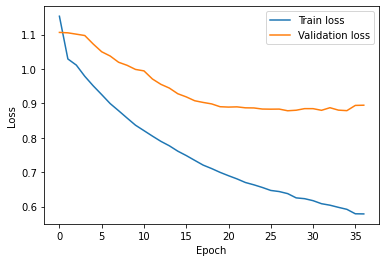

In [19]:
plt.plot(cnn.history[:, 'train_loss'], label='Train loss')
plt.plot(cnn.history[:, 'valid_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [20]:
cnn.load_params(checkpoint=cp)

y_pred = cnn.predict(X_val)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.74      0.74      0.74        34
           2       0.46      0.40      0.43        30

    accuracy                           0.60        88
   macro avg       0.59      0.60      0.59        88
weighted avg       0.60      0.60      0.60        88



In [22]:
y_probs = cnn.predict_proba(X_val)
y_probs[:10]

array([[0.58530104, 0.04546485, 0.36923406],
       [0.04333271, 0.6212834 , 0.33538392],
       [0.02334902, 0.7148449 , 0.26180607],
       [0.02414412, 0.7493779 , 0.22647792],
       [0.31622937, 0.2921475 , 0.39162308],
       [0.45035234, 0.0892497 , 0.460398  ],
       [0.00959289, 0.79456747, 0.19583969],
       [0.01284781, 0.7052605 , 0.28189167],
       [0.24009119, 0.00668284, 0.7532259 ],
       [0.3777745 , 0.16213979, 0.46008575]], dtype=float32)

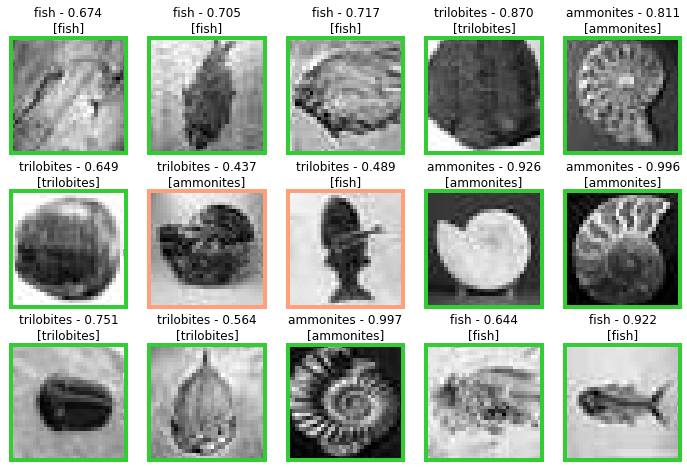

In [24]:
import utils

utils.visualize(X_val, y_val, y_probs,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_
               )

## The kernels

In [25]:
w1 = cnn.module_[0].weight.detach().numpy()
w1.shape

(32, 1, 3, 3)

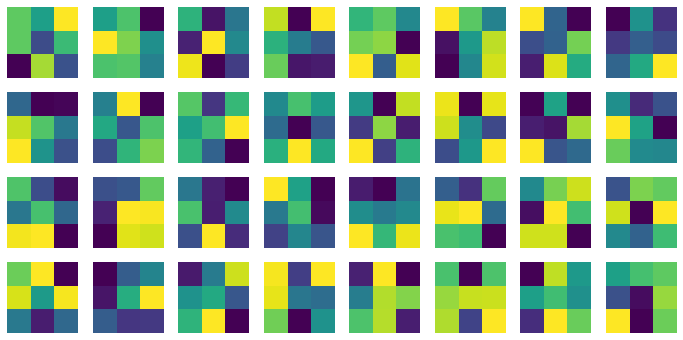

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for w, ax in zip(w1, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

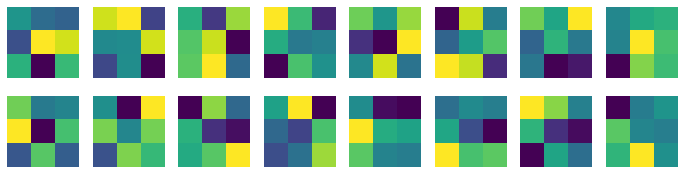

In [27]:
w2 = cnn.module_[3].weight.detach().numpy()

fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
for w, ax in zip(w2, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

## Using grid search with this network

In theory, you can also use `scikit-learn` training flow objects to train robust models such as `GridSearchCV`.

This is potentially cool, but I am not 100% certain that the models are initializing for each model. If you want to use this, I suggest reading the `skorch` docs carefully.

In [28]:
from sklearn.model_selection import GridSearchCV

cnn = NeuralNetClassifier(
    net,
    max_epochs=10,
    batch_size=100,
    optimizer=torch.optim.Adam,
)

params = {
    'lr': [0.001, 0.003],
}

gs = GridSearchCV(cnn, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6992       0.7164        0.6886  0.3013
      2        0.6426       0.6716        0.6863  0.2732
      3        0.6035       0.6866        0.6977  0.3028
      4        0.5857       0.7015        0.6834  0.3102
      5        0.5919       0.6716        0.7111  0.2915
      6        0.5845       0.6567        0.7340  0.2850
      7        0.5709       0.6567        0.7199  0.3061
      8        0.5705       0.6567        0.7325  0.3121
      9        0.5652       0.6567        0.7529  0.3154
     10        0.5575       0.6269        0.7451  0.3298
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7407       0.5821        0.8605  0.3465
      2        0.7125       0.6418        0.8749  0.3388
      3        0.6816       0.6269        0.8642  0.3624
      4        0.6660       0.5

## Model persistence

The easiest way to save a model is to `pickle` the trained model object.

In [29]:
import pickle

# Saving.
with open('torch_classifier.pkl', 'wb') as f:
    pickle.dump(cnn, f)

# Loading.
with open('torch_classifier.pkl', 'rb') as f:
    cnn = pickle.load(f)

In [31]:
cnn.initialize()
cnn.predict(X_val)

array([0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 2, 2,
       2, 1, 1, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 0,
       2, 2, 2, 2, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2])

---

&copy; 2020 Agile Scientific